<a href="https://colab.research.google.com/github/lisatwyw/data-gym/blob/master/Prophet_Subject999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oveview #

Getting started to data analyses using data from...



## A) Mount and create subfolder ```MUSE```##

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## B) Retrieve data entered on a Google spreadsheet ##

In [0]:
from google.colab import auth

auth.authenticate_user()

import gspread

from oauth2client.client import GoogleCredentials
gc= gspread.authorize(GoogleCredentials.get_application_default())

# public
url='https://docs.google.com/spreadsheets/d/1XFAyPqcigAaLK8W6I1P0IFAOoWXfSFnfGXTFUM-uGVw/'

wb= gc.open_by_url(url)

sheet = wb.worksheet('data')


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data = sheet.get_all_values()

df = pd.DataFrame( data )
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,Day,#,,Yeear,Month,Date,Time,SBP,DBP\n,Heart Rate,Side,
1,0,0,,2019,12,15,AM,153,84,66,,=sum($B$26:B27) '
2,1,1,,2019,12,15,AM,142,74,70,,
3,1,0,,2019,12,16,AM,147,80,71,,
4,1,0,,2019,12,16,AM,138,70,65,,


### Find indices of missing data ###

In [0]:
import numpy as np
t=np.asarray(df.values)
sbp = t[1:,7]
dbp = t[1:,8]
hr  = t[1:,9]

missing0 = np.where(sbp=='')[0]

yrs = t[1:,3]
missing1 = np.where(yrs=='')[0]

months = t[1:,4]
missing2 = np.where(months=='')[0]

dates = t[1:,5]
missing3 = np.where(dates=='')[0]

missing4 = np.where(dbp=='')[0]
missing5 = np.where(hr=='')[0]

In [0]:
missing = np.union1d( np.union1d( np.union1d(missing0, missing1 ), missing2), missing3 )

inds=np.setdiff1d( range(len(dates)), missing)

In [0]:
dates2 = pd.DataFrame( {'year': yrs[inds], 'month': months[inds], 'day': dates[inds] } )
dates2 = pd.to_datetime( dates2 )

### Find unique dates ###

In [0]:
I=[]
mapping = {}
for i in np.unique(dates2):  
    I.append( np.where(dates2 == i)[0][0]  )


### Create data frame for forecasting ###

In [19]:
dates_daily =dates2.values[I]
sbp_daily = sbp[inds].astype(int)[I] 
dbp_daily = dbp[inds].astype(int)[I] 
hr_daily = hr[inds].astype(int)[I] 

SBP = pd.DataFrame( {'ds':dates2, 'y': sbp[inds].astype(int), 'hr': hr[inds].astype(int)  })
print(SBP.head())

SBP_daily = pd.DataFrame( {'ds':dates_daily, 'y': sbp_daily, 'hr': hr_daily  })
print(SBP_daily.head())

          ds    y  hr
0 2019-12-15  153  66
1 2019-12-15  142  70
2 2019-12-16  147  71
3 2019-12-16  138  65
4 2019-12-16  147  69
          ds    y  hr
0 2019-12-15  153  66
1 2019-12-16  147  71
2 2019-12-19  122  75
3 2019-12-22  164  74
4 2019-12-24  119  70


## C) Try forecasting with Prophet ##


### Fit model... ###

In [10]:
from fbprophet import Prophet

model = Prophet(interval_width=0.95,);
model.fit(SBP[:-10]);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecast... ###

[Ref to parameters of ```freq```](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

In [0]:
pred_df = model.make_future_dataframe(periods=2, freq='D')
pred_df = model.predict(pred_df)


### Plot the results ###

Prophet plots observed values as black dots, forecasted values in blue line, and uncertainty intervals of the forecasts as blue-shaded regions


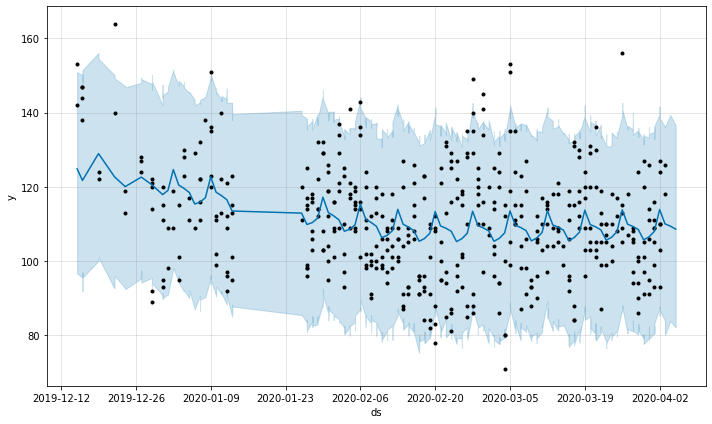

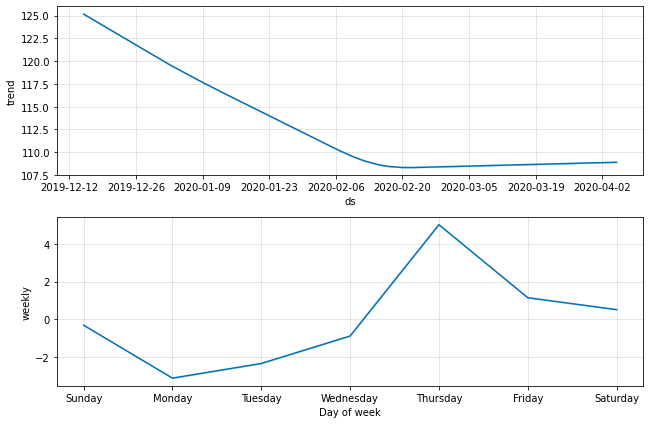

In [12]:
fig1 = model.plot(pred_df) 
fig2 = model.plot_components(pred_df)

### Refit SBP measured on each morning only ###

Assuming measurements done in morning are stored before those in the evening


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(83, 16)


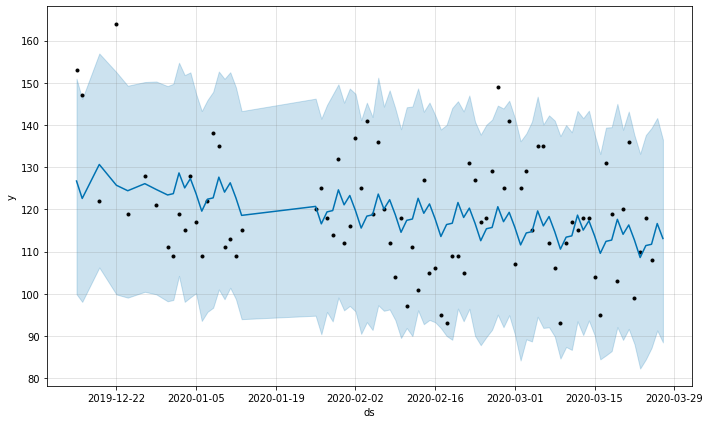

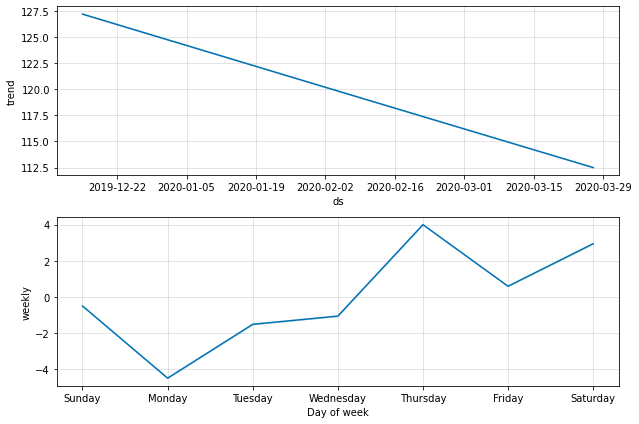

In [32]:
model = Prophet(interval_width=0.95)
model.fit(SBP_daily[:-10])

pred_df2 = model.make_future_dataframe(periods=2, freq='D')
pred_df2 = model.predict(pred_df2 )

fig1 = model.plot(pred_df2) 
fig2 = model.plot_components(pred_df2)

print( pred_df2.shape )

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


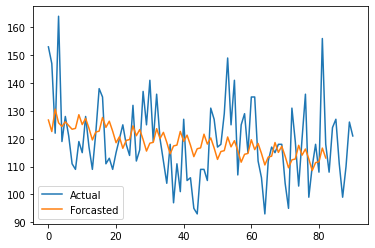

In [33]:
import matplotlib.pyplot as plt

plt.plot( SBP_daily.y , label='Actual')
print( pred_df2.keys() )
plt.plot( pred_df2.yhat, label='Forcasted' )
plt.legend()

In [15]:
SBP_daily.keys()
SBP_daily[:-10]

,ds,y,hr
0,2019-12-15,153,66
1,2019-12-16,147,71
2,2019-12-19,122,75
3,2019-12-22,164,74
4,2019-12-24,119,70
...,...,...,...
76,2020-03-21,136,91
77,2020-03-22,99,76
78,2020-03-23,110,83
79,2020-03-24,118,66


## D) Fit and forecast heart rate ##



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


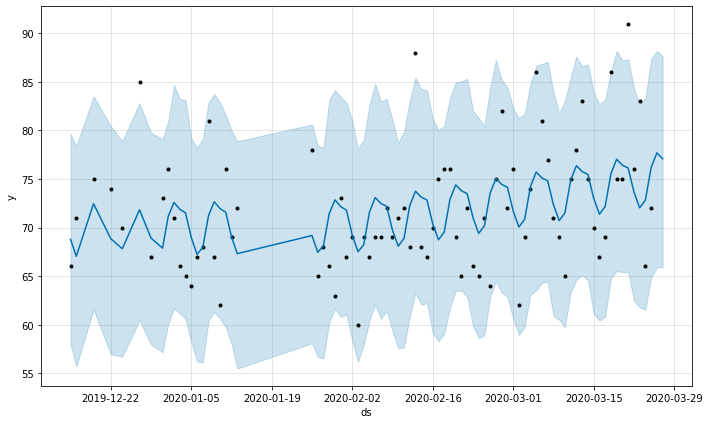

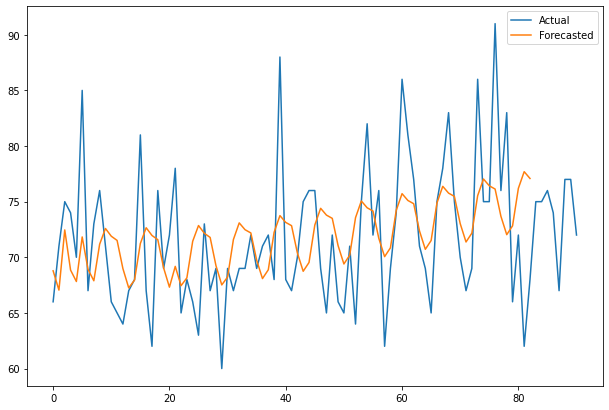

In [30]:
HR_daily = pd.DataFrame( {'ds':dates_daily, 'y': hr_daily,   })
DBP_daily = pd.DataFrame( {'ds':dates_daily, 'y': dbp_daily,  })

model = Prophet(interval_width=0.95)
model.fit( HR_daily[:-10])

pred_df5 = model.make_future_dataframe(periods=2, freq='D')
pred_df5 = model.predict(pred_df5 )

fig1 = model.plot(pred_df5) 
fig2 = model.plot_components(pred_df5)

plt.clf()
plt.plot( HR_daily.y, label='Actual' )
print( pred_df5.keys() )
plt.plot( pred_df5.yhat, label='Forecasted')
plt.legend()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


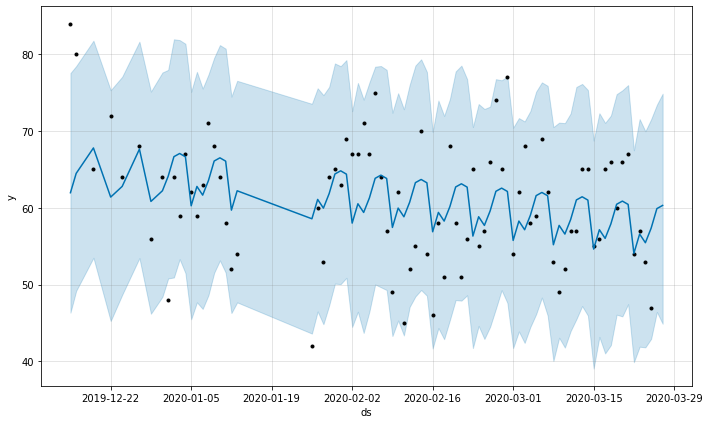

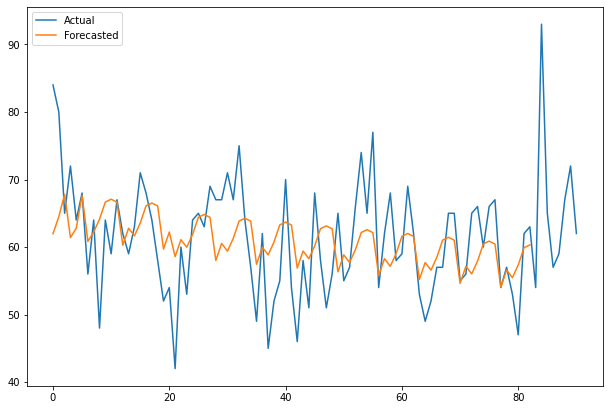

In [28]:
model = Prophet(interval_width=0.95)
model.fit( DBP_daily[:-10])

pred_df4 = model.make_future_dataframe(periods=2, freq='D')
pred_df4 = model.predict(pred_df4 )

fig1 = model.plot(pred_df4) 
fig2 = model.plot_components(pred_df4)

plt.clf()
plt.plot( DBP_daily.y, label='Actual' )
print( pred_df4.keys() )
plt.plot( pred_df4.yhat, label='Forecasted' )
plt.legend()